In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Perhaps this step can be skipped by saving directly to the workspace

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#package instalation

#Installing PROSAIL
!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
#!pip install pysptools

#TPE optimization packages
!pip install hyperopt
#!pip install hyperas


     |████████████████████████████████| 153kB 3.3MB/s 


In [ ]:
#the beutiful R like data frame
import pandas as pd

#the famous numpy 
import numpy as np

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#a few more stuff for random
import random as rdm
import math


# import the regressor for random forests
#from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor #this is the standard MLP regressor but i want to use keras

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adadelta, Adam, rmsprop



from sklearn import metrics



Using TensorFlow backend.


Bunch of functions needed for data generation

In [ ]:
def custom_prosail(cab,cw,cm,lai):
  import prosail
  #default parameters
  n= 1.
  car=10.
  cbrown=0.01
  typelidf=1 #this is the default option
  lidfa = -1 #leaf angle distribution parameter a and b
  lidfb=-0.15
  hspot= 0.01 #hotspot parameters - got this from R package https://www.rdocumentation.org/packages/hsdar/versions/0.4.1/topics/PROSAIL
  #sun and viewing angle
  tts=30. #observation and solar position parameters
  tto=10. 
  psi=0.
  #for now i put them by hand but they should be an input of a custom function
  #tts=sol_zen #solar zenith angle
  #tto=inc_zen #sensor zenith angle
  #psi=raa
  rho_out = prosail.run_prosail(n,
                                 cab,
                                 car,
                                 cbrown,
                                 cw,
                                 cm,
                                 lai,
                                 lidfa,
                                 hspot,
                                 tts,tto,psi,
                                 typelidf, lidfb,
                                 prospect_version="D",
                                 factor='SDR', 
                                 rsoil=.5, psoil=.5)
  return(rho_out)

def Prosail2S2(path2csv,spectra_input):
  #importing pandas
  import pandas as pd
  import numpy
  import numpy as np
  #upload a S2_Response.csv from https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/document-library/-/asset_publisher/Wk0TKajiISaR/content/sentinel-2a-spectral-responses

  s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec
  #chekc which row you are actually extracting

  s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
  spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
  rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
  w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

  output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

  return output[1:] #removes the first value because it represents the wavelength column

#please LOAD THTE FILE NOW
filepath="/content/drive/My Drive/S2_Response.csv"
#filepath="/content/S2_Responses_S2B.csv"
#filepath="/content/drive/My Drive/S2_Response.csv"


def Gen_spectra_data(traits):
  k = 1
  #pd_train_traits=traits
  #print(range(len(traits)))
  for i in range(len(traits)):
    #n_t = pd_train_traits["n"][i]
    cab_t = traits["cab"][i]
    #car_t = pd_train_traits["car"][i]
    #cbrown_t = pd_train_traits["cbrown"][i]
    cw_t = traits["cw"][i]
    cm_t = traits["cm"][i]
    lai_t = traits["lai"][i]

    if k == 1:
      tr_rho_s = custom_prosail(cab_t,cw_t,cm_t,lai_t)
      tr_rho_s = Prosail2S2(filepath,tr_rho_s)
      #plt.plot ( x, tr_rho_s, ':', label="Training prosail")
      #plt.legend(loc='best')
      
    if k > 1:
      tr_rho_t = custom_prosail(cab_t,cw_t,cm_t,lai_t)
      tr_rho_t = Prosail2S2(filepath,tr_rho_t)
      tr_rho_s = np.vstack((tr_rho_s,tr_rho_t))
      #plt.plot ( x, tr_rho_t, ':')

    k = k+1


  rho_samples=tr_rho_s


  return rho_samples




#Function to store the outputs into a table
column_names=["Model",
              "NSamples",
              "OutOfBag",
              "KFold_tr_samples",
              "KFold_vl_samples",
              "Variable",
              "Fold_nr",
              "ExplVar",
              "Max_err",
              "Mean_abs_Err",
              "Mean_sqr_err",
              #"Mean_sqr_lg_err",
              "Median_abs_err",
              "r2",
              "MAPE",
              "ModelName"]
              #"Mean_poiss_dev",
              #"Mean_gamma_dev"]
              #"Mean_tweed_dev"]

#mape is not existant in the package so we have to create it:
#https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
#from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

  #Here, the file is used for saving
  #creating a df to receive the data


def calc_metrics(MDL,Samples,oob_samples,kf_tr,kf_vl,Variable,Fold,Ref,Pred,Modelname):

  out_list = {"Model":MDL,
              "NSamples":Samples,
              "OutOfBag":oob_samples,
              "KFold_tr_samples":kf_tr,
              "KFold_vl_samples":kf_vl,
              "Variable":Variable,
              "Fold_nr":Fold,
              "ExplVar": metrics.explained_variance_score(Ref, Pred),
              "Max_err": metrics.max_error(Ref, Pred),
              "Mean_abs_Err": metrics.mean_absolute_error(Ref, Pred),
              "Mean_sqr_err": metrics.mean_squared_error(Ref, Pred),
              "Median_abs_err" : metrics.median_absolute_error(Ref, Pred),
              "r2": metrics.r2_score(Ref, Pred),
              "MAPE": mean_absolute_percentage_error(Ref, Pred),
              "ModelName":Modelname}


  return out_list

In [ ]:
# define an objective function

# These are a bunch of methods of te hyperopt package to generate the search space
from hyperopt import hp

# these are the minimizing function (fmin), Tree-parzen estimator method, an evaluation function, trial method and status indicators
from hyperopt import fmin, tpe, space_eval, Trials, STATUS_OK, STATUS_FAIL
from sklearn.model_selection import cross_val_score



Step 2: Generate the data that is going to be used for training




In [ ]:
#first the trait-space

n_traits=4 #I will test on 4 varying traits: cab, car, cw,cm,lai

#generating a LHS hypercube (it uses a 0 to 1 interval that can be used as a multiplier against the different traits)
np.random.seed(0)


#the values here are 1 less than the max so i can add a value later to it
#max_n=1 
max_cab=121. #add 1
#max_car=44. #add 1
#max_cbrown= 9.99 #add 0.01
max_cw=0.008 #add 0.001 
max_cm=0.008 #0.001
max_lai = 9.9 #add 0.1

min_cab = 10.
min_cw = 0.002
min_cm = 0.002
min_lai = .5

#set the number of samples used for the optimization
n_samples = 2000


In [ ]:
#this is for the training dataset
df_metrics = pd.DataFrame(columns=column_names)
#this is for the out of bag
df_metrics_valid = pd.DataFrame(columns=column_names)

#a path to store the models 
#path2folder = "/content/drive/My Drive/DSRP_Lunch_outputs/Models/"
#path2folder = "/content/drive/My Drive/RTM_Inversion/HyperParameterTunning/RandF/"

#generating trait space and data
LHS_train = lhsmdu.createRandomStandardUniformMatrix(n_traits,n_samples)
pd_trait = pd.DataFrame.transpose(pd.DataFrame(LHS_train))
pd_trait.columns = ["cab","cw","cm","lai"]

pd_trait["cab"]=pd_trait["cab"]*max_cab+min_cab
pd_trait["cw"] =pd_trait["cw"] *max_cw+min_cw
pd_trait["cm"] =pd_trait["cm"] *max_cm+min_cw
pd_trait["lai"]=pd_trait["lai"]*max_lai+min_lai

#this is the same as above but on numpy format
np_trait = pd_trait.iloc[:,:].values

#now we first generate the date in hyperspectral, convolute it to S2 while iterating through the entire given trait space
np_spect = Gen_spectra_data(pd_trait)[:,[1,2,3,4,5,6,8,11,12]]

#now we remove 10% of the data for out-of-bag validation of the final model while the cross-validation happens within the hyperparemeter tunning
index = list(range(len(np_spect)))
index10 = rdm.sample(index,math.ceil(len(index)*.1))
index90 = [x for x in index if x not in index10]

#selecting the groups for training (tr) and validation (vl)
tr_trait_df = np_trait[index90,]
tr_spect_df = np_spect[index90,]

vl_trait_df = np_trait[index10,]
vl_spect_df = np_spect[index10,]



Creating the ANN function call

In [ ]:
def st_ann(params):

  from keras.models import Sequential
  from keras.layers.core import Dense, Activation
  from keras.optimizers import Adadelta, Adam, rmsprop

  mdl = Sequential()
  #mdl.add(Dense(units=params['units_1'],input_dim=9,activation=params['activation_1']))
  #mdl.add(Activation(params['activation_1']))
  #print("This is the dictionary")
  #print(params)

  hiddenlayers = units=params['aa_hiddenlayers']
  
  if hiddenlayers == 'one':
    mdl.add(Dense(units=params['units_1_1'],input_dim=9,activation=params['activation_1_1']))

    #and the output layer
    mdl.add(Dense(4,activation='linear'))
    #mdl.add(Activation("linear"))
    mdl.compile(loss='mean_squared_error', optimizer=params['optimizer_1'], metrics=['mean_squared_error'])
  
  if hiddenlayers == 'two':
    mdl.add(Dense(units=params['units_2_1'],input_dim=9,activation=params['activation_2_1']))
    mdl.add(Dense(units=params['units_2_2'],activation=params['activation_2_2']))

    #and the output layer
    mdl.add(Dense(4,activation='linear'))
    #mdl.add(Activation("linear"))
    mdl.compile(loss='mean_squared_error', optimizer=params['optimizer_2'], metrics=['mean_squared_error'])
    
  if hiddenlayers == 'three':
    mdl.add(Dense(units=params['units_3_1'],input_dim=9,activation=params['activation_3_1']))
    mdl.add(Dense(units=params['units_3_2'],activation=params['activation_3_2']))
    mdl.add(Dense(units=params['units_3_3'],activation=params['activation_3_3']))

    #and the output layer
    mdl.add(Dense(4,activation='linear'))
    #mdl.add(Activation("linear"))
    mdl.compile(loss='mean_squared_error', optimizer=params['optimizer_3'], metrics=['mean_squared_error'])


  return mdl


#first we define the function
N_FOLDS = 5
MAX_EVALS = 200

#here we can just fetch the data so we keep everything in one place
train_labels = tr_trait_df = np_trait[index90,]
train_features = tr_spect_df = np_spect[index90,]

#preparing the data for the neural network

from sklearn.model_selection import KFold 
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

N_FOLDS = 10
kf = KFold(n_splits=N_FOLDS,shuffle=True,random_state=42)

scaler = MinMaxScaler()
scaler.fit(train_labels)
Y_train_norm = scaler.transform(train_labels)




def objective(params, n_folds = N_FOLDS):
    #"""Objective function for Random forest Hyperparameter Tuning"""

    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evaluate based on ROC AUC
    #rf = RandomForestRegressor(**params, random_state = 42,bootstrap=True,oob_score=True)
    #print ('Params testing: ', params)
    ann_ml = st_ann(params)


    #the regular cross_val_score does not work with keras
    #scores = cross_val_score(ann_ml, X=train_features, y=train_labels, cv=10, scoring='neg_mean_absolute_error') #thi is the simple Mean abs

    #so we have to do it ourselves
    scores = np.empty((0,4)) #an empty arrray to holdout all the results of the kfoldind

    for train_index,test_index in kf.split(train_features):
      #folding the data input
      x_train_k,x_test_k = train_features[train_index],train_features[test_index]
      y_train_k,y_test_k = Y_train_norm[train_index],Y_train_norm[test_index] #fetches the data already transformed

      ann_ml.fit(x_train_k, y_train_k,
                epochs=50,
                verbose=0)
      
      outval = ann_ml.predict(x_test_k)

      #storing all MAE outputs of the neural network -> significant notion, since i am already on the scaled data, its okish to measure the MAE like this since all values vary
      #in same ranges between a min and max
      score = [metrics.mean_absolute_error(y_test_k[:,0], outval[:,0]),
               metrics.mean_absolute_error(y_test_k[:,1], outval[:,1]),
               metrics.mean_absolute_error(y_test_k[:,2], outval[:,2]),
               metrics.mean_absolute_error(y_test_k[:,3], outval[:,3])]
      
      #and appending it to the block
      scores=np.append(scores,score)    


    # Extract the best score
    best_score = np.mean(abs(scores)) #mean value
    # if the the result is miniming

    # Loss must be minimized
    #loss = 1 - best_score 
    loss = best_score 

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}


SPACE = hp.choice('aa_hiddenlayers', [
    {
        'aa_hiddenlayers': 'one',
        'units_1_1': hp.choice('units_1_1', [5,10,15,20]),
        'activation_1_1': hp.choice('activation_1_1', ['linear', 'sigmoid','tanh','exponential','softplus','relu','softsign']),
        'optimizer_1': hp.choice('optimizer_1', ['adam','RMSprop','Adadelta'])
    },
    {
        'aa_hiddenlayers': 'two',
        'units_2_1': hp.choice('units_2_1', [5,10,15,20]),
        'activation_2_1': hp.choice('activation_2_1', ['linear', 'sigmoid','tanh','exponential','softplus','relu','softsign']),
        'units_2_2': hp.choice('units_2_2', [5,10,15,20]),
        'activation_2_2': hp.choice('activation_2_2', ['linear', 'sigmoid','tanh','exponential','softplus','relu','softsign']),
        'optimizer_2': hp.choice('optimizer_2', ['adam','RMSprop','Adadelta'])        
    },
    {
        'aa_hiddenlayers': 'three',
        'units_3_1': hp.choice('units_3_1', [5,10,15,20]),
        'activation_3_1': hp.choice('activation_3_1', ['linear', 'sigmoid','tanh','exponential','softplus','relu','softsign']),
        'units_3_2': hp.choice('units_3_2', [5,10,15,20]),
        'activation_3_2': hp.choice('activation_3_2', ['linear', 'sigmoid','tanh','exponential','softplus','relu','softsign']),
        'units_3_3': hp.choice('units_3_3', [5,10,15,20]),
        'activation_3_3': hp.choice('activation_3_3', ['linear', 'sigmoid','tanh','exponential','softplus','relu','softsign']),
        'optimizer_3': hp.choice('optimizer_3', ['adam','RMSprop','Adadelta'])           
    },
    ])




#this works somehow but its making sets that are non-sensical
# space = {
#     'hiddenlayers': hp.choice('hiddenlayers', [1,2,3]),
#     'units_1': hp.choice('units_1', [1,2,3,4,5,6,7,8,9,10]), #to avoid errors (e.g. to few trees)
#     'activation_1': hp.choice('activation_1', ['linear', 'sigmoid','tanh','exponential','softplus','relu','softsign']), #these must be a fractio up to 50% of the data it seems
#     'units_2_1': hp.choice('units_2_1', [1,2,3,4,5,6,7,8,9,10]),
#     'units_3_1': hp.choice('units_3_1', [1,2,3,4,5,6,7,8,9,10]),
#     'units_3_2': hp.choice('units_3_2', [1,2,3,4,5,6,7,8,9,10]),
#     'activation_2_1': hp.choice('activation_2_1', ['linear', 'sigmoid','tanh','exponential','softplus','relu','softsign']),
#     'activation_3_1': hp.choice('activation_3_1', ['linear', 'sigmoid','tanh','exponential','softplus','relu','softsign']),
#     'activation_3_2': hp.choice('activation_3_2', ['linear', 'sigmoid','tanh','exponential','softplus','relu','softsign']),
# }

In [ ]:
bayes_trials = Trials()

best_ann = fmin(fn = objective, space = SPACE, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials,verbose=1)

100%|██████████| 200/200 [1:29:08<00:00, 26.74s/it, best loss: 0.030830829069638015]


In [ ]:
best_ann

{'aa_hiddenlayers': 2,
 'activation_3_1': 6,
 'activation_3_2': 6,
 'activation_3_3': 5,
 'optimizer_3': 0,
 'units_3_1': 3,
 'units_3_2': 3,
 'units_3_3': 2}

In [ ]:
hiddenlayer = {0:'one',1:'two',2:'three'}
activation_f = {0:'linear', 1:'sigmoid', 2:'tanh',3:'exponential',4:'softplus',5:'relu',6:'softsign'}
units_shared = {0: 5,1: 10,2: 15,3: 20}
units_traits = {0:1,1:2,2:3,3:4,4:5,5:6,6:7,7:8,8:9,9:10}
optimizer = {0: 'adam',1: 'RMSprop',2: 15,3: 'Adadelta'}

param_dict = {'aa_hiddenlayers':hiddenlayer[2],
              'activation_3_1': activation_f[6],
              'activation_3_2': activation_f[6],
              'activation_3_3': activation_f[5],
              'optimizer_3': optimizer[0],
              'units_3_1': units_shared[3],
              'units_3_2': units_shared[3],
              'units_3_3': units_shared[2]}
param_dict

{'aa_hiddenlayers': 'three',
 'activation_3_1': 'softsign',
 'activation_3_2': 'softsign',
 'activation_3_3': 'relu',
 'optimizer_3': 'adam',
 'units_3_1': 20,
 'units_3_2': 20,
 'units_3_3': 15}

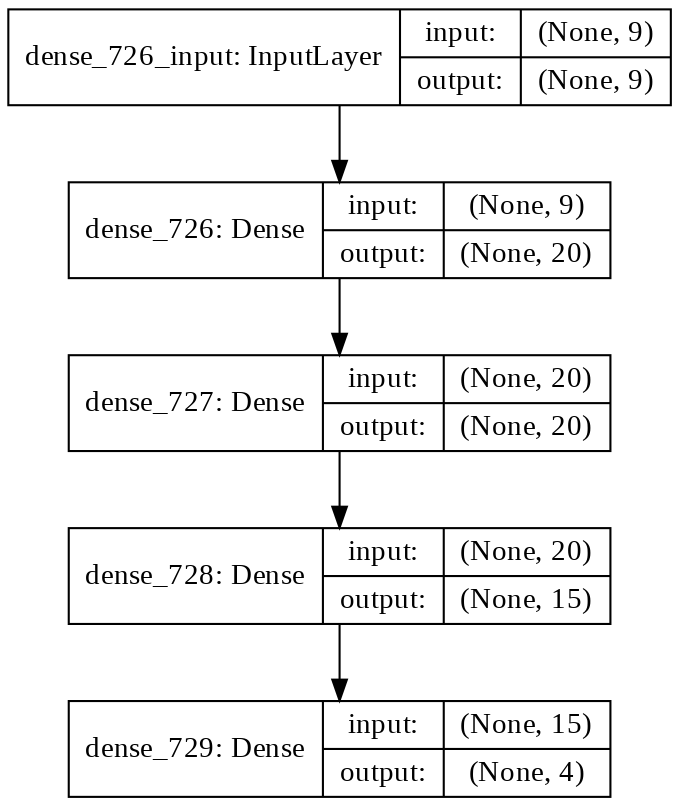

In [ ]:
ann_ml = st_ann(param_dict)

from keras.utils import plot_model
print(ann_ml)

dot_img_file = '/content/drive/My Drive/Agustin/model_1.png'
plot_model(ann_ml, to_file=dot_img_file, show_shapes=True,dpi=150)